In [10]:
!pip install pysindy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
pip install wfdb

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.0 MB 5.6 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 5.6 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 5.6 MB/s eta 0:00:02
   --------------------- ------------------ 6.0/11.0 MB 5.7 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 5.7 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 5.7 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.0 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 5.4 MB/s eta 0:00:00

  Attempting

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#Population level ODE without MSM and GPS
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import pysindy as ps

# Load and combine all patient data
processed_patients = []

for i in range(1, 29):
    try:
        filename = f"HUPA{i:04d}P.csv"
        df_patient = pd.read_csv(filename, sep=';')
       # df_patient.drop(['time', 'steps','heart_rate'], axis=1, inplace=True)
        new_time = np.arange(0, 5*len(df_patient), 5)
        df_subset = df_patient.iloc[:len(new_time)].copy()
        df_subset['time'] = new_time
        df_subset.set_index('time', inplace=True)
        df_subset['patient_id'] = i
        processed_patients.append(df_subset)
    except Exception as e:
        print(f"Error with patient {i}: {e}")   
        

combined_df = pd.concat(processed_patients, axis=0)

# Discover the Population ODE
features = ["glucose","carb_input", "bolus_volume_delivered", "basal_rate"]
X = combined_df[features].dropna()
X_smooth = X.apply(lambda col: savgol_filter(col, window_length=5, polyorder=2), axis=0)
X_np = X_smooth.to_numpy()

dt = 5.0
optimizer = ps.STLSQ(threshold=0.0001)
library = ps.PolynomialLibrary(degree=2)

#here we use SINDy to get ODE equations
model_population = ps.SINDy(optimizer=optimizer, feature_library=library, feature_names=['G', 'c', 'ba', 'bo'] )
model_population.fit(X_np, t=dt)



print("Population ODE without MSM")
print(model_population.equations()[0])


Error with patient 8: [Errno 2] No such file or directory: 'HUPA0008P.csv'
Error with patient 12: [Errno 2] No such file or directory: 'HUPA0012P.csv'
Error with patient 13: [Errno 2] No such file or directory: 'HUPA0013P.csv'
Population ODE without MSM
0.002 1 + -0.011 c + 0.021 ba + 0.118 bo + -0.001 G bo + -0.005 c ba + -0.174 c bo + 0.001 ba^2 + 0.328 ba bo + -2.642 bo^2


In [8]:
# ODE's for Population using MSM & Sindy (population-only)
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import pysindy as ps

# 1) Combining data of all the patients
def load_patient_one(patient_id, filepath="HUPA{:04d}P.csv"):
    try:
        df = pd.read_csv(filepath.format(patient_id), sep=';')
    except Exception as e:
       return None

    df = df.copy()
    df['patient_id'] = patient_id

    # creating lag variables 
    for col in ['steps', 'carb_input', 'glucose', 'basal_rate', 'heart_rate','bolus_volume_delivered']:
        df[f'{col}_lag1'] = df[col].shift(1)

    df = df.dropna().reset_index(drop=True)
    for col in df.columns:
        if col != 'time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna().reset_index(drop=True)
    return df

def load_patients_all(no_patients=28, filepath="HUPA{:04d}P.csv"):
    dfs = []
    for pid in range(1, no_patients+1):
        dfp = load_patient_one(pid, filepath)
        if dfp is not None:
            dfs.append(dfp)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return None

# 2) Defining GPS with TWO continuous treatments- both basal and bolus are treatments 
def iptw_gps_multi(df, treatments=('basal_rate','bolus_volume_delivered'),
                   confounders=('glucose_lag1','carb_input_lag1','heart_rate_lag1','steps_lag1'),
                   eps=1e-3):
   
    d = df.copy()

    # Log-transform to avoid zeros
    Y = np.log(np.clip(d[list(treatments)].values, 0, None) + eps)

    X = sm.add_constant(d[list(confounders)], has_constant='add')
    ols = [sm.OLS(Y[:, j], X).fit() for j in range(Y.shape[1])]
    mu_cond = np.column_stack([m.predict(X) for m in ols])

    # residuals covariance
    resid = Y - mu_cond
    Sigma_cond = np.cov(resid.T)
    Sigma_cond += 1e-6 * np.eye(Sigma_cond.shape[0])  # stabilizer

    f_cond = multivariate_normal.pdf(Y, mean=Y.mean(axis=0), cov=Sigma_cond)
    f_marg = multivariate_normal.pdf(Y, mean=Y.mean(axis=0), cov=np.cov(Y.T))

    w = f_marg / f_cond
    d['iptw'] = np.clip(w, 0.01, 20.0)
    return d

# 3) ODE of a Population using MSM & Sindy
def population_msm_sindy(df, dt=5.0):
    confounders = ['glucose_lag1','carb_input_lag1','heart_rate_lag1','steps_lag1']  
    df = iptw_gps_multi(df, treatments=('basal_rate','bolus_volume_delivered'),
                        confounders=confounders)

    predictors = ['basal_rate','bolus_volume_delivered','carb_input',
                  'glucose_lag1','heart_rate_lag1','steps_lag1']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[predictors])
    X_msm = sm.add_constant(pd.DataFrame(X_scaled, columns=predictors, index=df.index),
                            has_constant='add')

    msm = sm.WLS(df['glucose'], X_msm, weights=df['iptw']).fit() 
    #glucose values adjusted for confounding
    df['glucose_adjusted'] = df['glucose'] - msm.predict(X_msm) + df['glucose'].mean()
    
    #here we take glucose adjusted through msm and not the original glucose value
    ode_features = ['glucose_adjusted','carb_input','basal_rate','bolus_volume_delivered']
    X_ode = StandardScaler().fit_transform(df[ode_features].to_numpy(dtype=float))

    #again sindy is used for getting ode
    opt = ps.STLSQ(threshold=1e-4)
    lib = ps.PolynomialLibrary(degree=2)
    sindy = ps.SINDy(optimizer=opt, feature_library=lib,
                     feature_names=['G','c','ba','bo'])
    sindy.fit(X_ode, t=dt)

    return sindy.equations()[0]  # return only the ODE for G

# 4) Print only the population ODE
if __name__ == "__main__":
    df_all = load_patients_all(no_patients=28)
    if df_all is not None:
        ode_eq = population_msm_sindy(df_all, dt=5.0)
        print("Population ODE with MSM")
        print(ode_eq)
    else:
        print("No patient data available.")


Population ODE with MSM
0.001 1 + 0.002 G + 0.001 c + -0.006 bo + -0.001 G^2 + -0.001 G c + 0.002 G ba + -0.010 G bo + -0.003 c ba + 0.001 ba bo





Y.shape=(309367, 2), mu_cond.shape=(309367, 2)
Sigma_cond.shape=(2, 2), mu_marg.shape=(2,), Sigma_marg.shape=(2, 2)
count    309367.000000
mean          1.002501
std           0.484170
min           0.010000
25%           0.925157
50%           0.973705
75%           1.032274
max          20.000000
Name: iptw, dtype: float64

=== Horizon 3 steps (~15 min) ===
  rmse_direct: 28.586  (95% CI ±2.931)   n=25
  rmse_msm: 16.840  (95% CI ±1.654)   n=25
  mae_direct: 17.665  (95% CI ±1.801)   n=25
  mae_msm: 10.227  (95% CI ±1.028)   n=25
  sign_meal_msm: 0.908  (95% CI ±0.060)   n=4
  sign_bolus_msm: 0.825  (95% CI ±0.044)   n=19

=== Horizon 6 steps (~30 min) ===
  rmse_direct: 42.364  (95% CI ±4.286)   n=25
  rmse_msm: 16.221  (95% CI ±1.466)   n=25
  mae_direct: 28.092  (95% CI ±2.894)   n=25
  mae_msm: 10.840  (95% CI ±1.015)   n=25
  sign_meal_msm: 0.902  (95% CI ±0.096)   n=4
  sign_bolus_msm: 0.917  (95% CI ±0.029)   n=19

=== Horizon 12 steps (~60 min) ===
  rmse_direct: 58.233  (

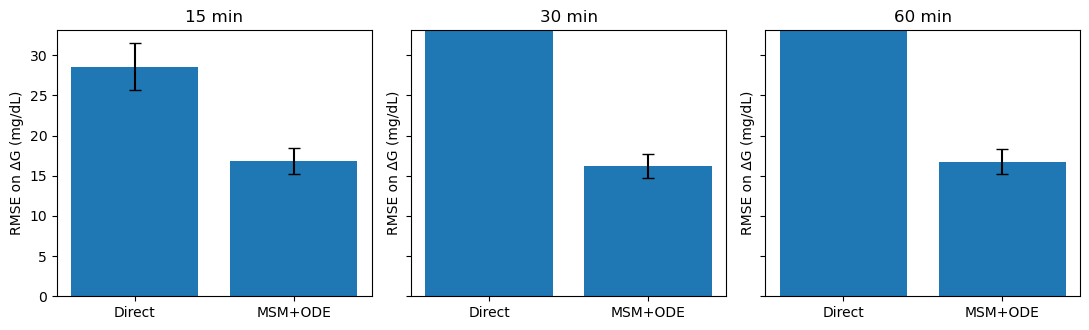

In [1]:
# ================================================================
# Short-horizon validation for Direct SINDy vs MSM+GPS→SINDy (ΔG)
# ================================================================
# Assumptions about CSV columns:
#   'glucose','carb_input','basal_rate','bolus_volume_delivered',
#   'steps','heart_rate'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import statsmodels.api as sm
from scipy.stats import multivariate_normal
import pysindy as ps
from collections import defaultdict
from scipy.stats import multivariate_normal   


# 0) combining all the data of the patients 

def load_all_patients(n=28, pattern="HUPA{:04d}P.csv", sep=';'):
    dfs = []
    for pid in range(1, n+1):
        try:
            df = pd.read_csv(pattern.format(pid), sep=sep)
            df["patient_id"] = pid
            dfs.append(df)
        except Exception as e:
          print()
    if not dfs:
        raise RuntimeError("No patient files loaded.")
    return pd.concat(dfs, ignore_index=True)


# 1) Preprocess + lags + smooth

def preprocess(df_raw, dt_min=5):
    """
    - Sort per patient & reset time index to 5-min grid
    - Create 1-step lags within each patient
    - Savitzky–Golay smooth the key series (per patient)
    """
    need_cols = ["glucose","carb_input","basal_rate","bolus_volume_delivered",
                 "steps","heart_rate","patient_id"]
    for c in need_cols:
        if c not in df_raw.columns:
            raise ValueError(f"Missing column: {c}")

    # sort by patient then original order
    df = df_raw.copy()
    df = df.sort_values(["patient_id"]).reset_index(drop=True)

    # reindex each patient to a uniform 5-min grid and smooth within patient
    out = []
    for pid, g in df.groupby("patient_id", sort=False):
        g = g.reset_index(drop=True).copy()
        g["time"] = np.arange(0, dt_min*len(g), dt_min)  # in minutes
        g = g.set_index("time")

        # SG smoothing for continuous series
        for col in ["glucose","carb_input","basal_rate","bolus_volume_delivered"]:
            if len(g[col]) >= 7 and g[col].notna().sum() >= 7:
                g[col] = savgol_filter(g[col].interpolate(limit_direction="both"),
                                       window_length=7, polyorder=2, mode="interp")

        # lags (1 step = 5 min) within patient
        for col in ["glucose","carb_input","steps","heart_rate",
                    "basal_rate","bolus_volume_delivered"]:
            g[f"{col}_lag1"] = g[col].shift(1)

        g = g.dropna()
        out.append(g)

    dfp = pd.concat(out).reset_index()   # keep 'time' as a column
    return dfp

# ------------------------------
# 2) GPS/weights (two doses)
from scipy.stats import multivariate_normal
import numpy as np
import statsmodels.api as sm

def pdf_rowwise(Y, mean_rows, cov):
    """Row-wise MVN pdf: each row of Y uses its own mean (mean_rows[i])."""
    return np.array([multivariate_normal.pdf(Y[i], mean=mean_rows[i], cov=cov)
                     for i in range(Y.shape[0])])

def iptw_gps_multi(df, treatments=('basal_rate','bolus_volume_delivered'),
                   confounders=('glucose_lag1','carb_input_lag1','heart_rate_lag1','steps_lag1'),
                   eps=1e-3, debug=False):
    d = df.copy()

    # 1) log-doses
    Y = np.log(np.clip(d[list(treatments)].values, 0, None) + eps)  # shape (n,2)

    # 2) conditional mean via OLS for each dose component
    X = sm.add_constant(d[list(confounders)], has_constant='add')   # shape (n,k)
    ols = [sm.OLS(Y[:, j], X).fit() for j in range(Y.shape[1])]
    mu_cond = np.column_stack([m.predict(X) for m in ols])          # shape (n,2)

    # 3) residual covariance (denominator)
    resid = Y - mu_cond
    Sigma_cond = np.cov(resid.T)
    Sigma_cond += 1e-6 * np.eye(Sigma_cond.shape[0])

    # 4) marginal mean & covariance (numerator)
    mu_marg  = Y.mean(axis=0)                 # shape (2,)
    Sigma_marg = np.cov(Y.T) + 1e-6*np.eye(Y.shape[1])

    # 5) row-wise densities
    den = pdf_rowwise(Y, mu_cond,  Sigma_cond)     # shape (n,)
    num = multivariate_normal.pdf(Y, mean=mu_marg, cov=Sigma_marg)  # vectorized; shape (n,)

    w = np.clip(num / den, 0.01, 20.0)
    d['iptw'] = w

    if debug:
        print(f"Y.shape={Y.shape}, mu_cond.shape={mu_cond.shape}")
        print(f"Sigma_cond.shape={Sigma_cond.shape}, mu_marg.shape={mu_marg.shape}, Sigma_marg.shape={Sigma_marg.shape}")

    gps_fits = dict(mu_cond=mu_cond, Sigma_cond=Sigma_cond, mu_marg=mu_marg, Sigma_marg=Sigma_marg)
    return d, gps_fits




# ------------------------------
# 3) MSM residualization
# ------------------------------
def residualize_glucose(df_w, gps_fits):
    """
    Weighted working model: G_t ~ (ba, bo, c, G_{t-1}, HR_{t-1}, S_{t-1})
    Uses df_w['iptw'] as weights. Adds columns 'Ghat' and 'G_adj'.
    Returns the fitted WLS model and the updated df_w.
    """
    X = sm.add_constant(df_w[['basal_rate','bolus_volume_delivered','carb_input',
                              'glucose_lag1','heart_rate_lag1','steps_lag1']], has_constant='add')
    y = df_w['glucose'].values
    w = df_w['iptw'].values

    wls = sm.WLS(y, X, weights=w).fit()
    df_w['Ghat']  = wls.predict(X)
    df_w['G_adj'] = df_w['glucose'] - df_w['Ghat'] + df_w['glucose'].mean()
    return wls, df_w

# ------------------------------
# 4) Fit SINDy (Direct and MSM)
# ------------------------------
def fit_sindy_direct(df, dt=5.0):
    X = df[["glucose","carb_input","basal_rate","bolus_volume_delivered"]].to_numpy()
    lib = ps.PolynomialLibrary(degree=2)
    opt = ps.STLSQ(threshold=1e-4)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     feature_names=["G","c","ba","bo"])
    model.fit(X, t=dt)
    return model

def fit_sindy_msm(df, dt=5.0):
    X = df[["G_adj","carb_input","basal_rate","bolus_volume_delivered"]].to_numpy()
    lib = ps.PolynomialLibrary(degree=2)
    opt = ps.STLSQ(threshold=1e-4)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     feature_names=["G_adj","c","ba","bo"])
    model.fit(X, t=dt)
    return model

# ------------------------------
# 5) Rollout evaluators
# ------------------------------
def euler_rollout_sindy(model, y0, inputs_window, dt=5.0, var_index=0):
    """
    model: fitted pysindy SINDy
    y0: starting state for the first variable (G or G_adj)
    inputs_window: array of shape (h, 3) with columns (c,ba,bo)
    dt: minutes per step (5)
    var_index: index of the state whose derivative to use (0)
    """
    y = float(y0)
    for (c, ba, bo) in inputs_window:
        x = np.array([[y, c, ba, bo]])  # shape (1,4)
        dy_dt = model.predict(x)[0, var_index]  # derivative of the first variable
        y = y + dt * dy_dt
    return y

def evaluate_combined(df, model_direct, model_msm,
                      horizons=(3,6,12), stride=12, dt=5.0,
                      meal_thr=5.0, bolus_thr=0.5):
    """
    Combined-data evaluation. Computes patient-level metrics then aggregates.
    Returns dict with per-horizon means and 95% CIs.
    """
    # prepare per-patient containers
    per_patient = {h: {"rmse_direct":[], "rmse_msm":[],
                       "mae_direct":[],  "mae_msm":[],
                       "sign_meal_msm":[], "sign_bolus_msm":[]}
                   for h in horizons}

    for pid, g in df.groupby("patient_id", sort=False):
        g = g.copy().reset_index(drop=True)
        # for faster lookups
        G      = g["glucose"].to_numpy()
        Gadj   = g["G_adj"].to_numpy()
        Ghat   = g["Ghat"].to_numpy()
        c_arr  = g["carb_input"].to_numpy()
        ba_arr = g["basal_rate"].to_numpy()
        bo_arr = g["bolus_volume_delivered"].to_numpy()

        max_h = max(horizons)
        starts = np.arange(0, len(g)-max_h, stride)  # non-overlapping hour windows

        for h in horizons:
            dG_obs_list, dG_dir_list, dG_msm_list = [], [], []
            meal_obs, meal_pred = [], []
            bolus_obs, bolus_pred = [], []

            for t0 in starts:
                t1 = t0 + h
                # inputs over the horizon (h steps)
                inputs = np.column_stack([c_arr[t0:t1], ba_arr[t0:t1], bo_arr[t0:t1]])
                if inputs.shape[0] < h:
                    continue

                # Direct rollout on raw G
                G0 = G[t0]
                G_end_pred = euler_rollout_sindy(model_direct, G0, inputs, dt=dt, var_index=0)

                # MSM rollout on G_adj, then map back to raw G using ΔGadj + (Ghat_t+h - Ghat_t)
                Gadj0 = Gadj[t0]
                Gadj_end_pred = euler_rollout_sindy(model_msm, Gadj0, inputs, dt=dt, var_index=0)

                dG_obs = G[t1] - G0
                dG_dir = G_end_pred - G0
                dG_msm = (Gadj_end_pred - Gadj0) + (Ghat[t1] - Ghat[t0])

                dG_obs_list.append(dG_obs)
                dG_dir_list.append(dG_dir)
                dG_msm_list.append(dG_msm)

                # event sign checks at window start
                if c_arr[t0] >= meal_thr:
                    meal_obs.append(dG_obs); meal_pred.append(dG_msm)
                if bo_arr[t0] >= bolus_thr:
                    bolus_obs.append(dG_obs); bolus_pred.append(dG_msm)

            # compute patient-level metrics for this horizon
            if len(dG_obs_list) == 0:
                continue
            dG_obs = np.array(dG_obs_list)
            d_dir  = np.array(dG_dir_list)
            d_msm  = np.array(dG_msm_list)

            rmse = lambda a,b: np.sqrt(np.mean((a-b)**2))
            mae  = lambda a,b: np.mean(np.abs(a-b))
            sacc = lambda a,b: np.mean(np.sign(a)==np.sign(b)) if len(a)>0 else np.nan

            per_patient[h]["rmse_direct"].append(rmse(d_dir, dG_obs))
            per_patient[h]["rmse_msm"].append(rmse(d_msm, dG_obs))
            per_patient[h]["mae_direct"].append(mae(d_dir, dG_obs))
            per_patient[h]["mae_msm"].append(mae(d_msm, dG_obs))
            if len(meal_obs)>0:
                per_patient[h]["sign_meal_msm"].append(sacc(np.array(meal_pred), np.array(meal_obs)))
            if len(bolus_obs)>0:
                per_patient[h]["sign_bolus_msm"].append(sacc(np.array(bolus_pred), np.array(bolus_obs)))

    # aggregate across patients: mean ± 95% CI
    def mean_ci(xs):
        xs = np.array(xs, dtype=float)
        xs = xs[~np.isnan(xs)]
        if len(xs)==0:
            return (np.nan, np.nan)
        m = xs.mean()
        se = xs.std(ddof=1)/np.sqrt(len(xs))
        return (m, 1.96*se)

    summary = {}
    for h in horizons:
        row = {}
        for k,v in per_patient[h].items():
            m, ci = mean_ci(v)
            row[k] = (m, ci, len(v))
        summary[h] = row
    return summary

def print_summary(summary):
    for h, row in summary.items():
        print(f"\n=== Horizon {h} steps (~{h*5} min) ===")
        for metric in ["rmse_direct","rmse_msm","mae_direct","mae_msm",
                       "sign_meal_msm","sign_bolus_msm"]:
            m, ci, n = row[metric]
            if np.isnan(m):
                print(f"  {metric}: n=0")
            else:
                print(f"  {metric}: {m:.3f}  (95% CI ±{ci:.3f})   n={n}")

def plot_rmse_bars(summary, savepath=None):
    horizons = sorted(summary.keys())
    direct = [summary[h]["rmse_direct"][0] for h in horizons]
    msm    = [summary[h]["rmse_msm"][0]    for h in horizons]
    ci_d   = [summary[h]["rmse_direct"][1] for h in horizons]
    ci_m   = [summary[h]["rmse_msm"][1]    for h in horizons]

    fig, axes = plt.subplots(1, 3, figsize=(11,3.4), sharey=True)
    titles = [f"{h*5} min" for h in horizons]
    for ax, title, d, m, cid, cim in zip(axes, titles, direct, msm, ci_d, ci_m):
        ax.bar(["Direct","MSM+ODE"], [d, m], yerr=[cid, cim], capsize=4)
        ax.set_title(title)
        ax.set_ylabel("RMSE on ΔG (mg/dL)")
        ax.set_ylim(bottom=0)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    # 1) Load + preprocess your combined data as you already do
    df0 = load_all_patients(n=28, pattern="HUPA{:04d}P.csv", sep=';')
    df  = preprocess(df0, dt_min=5)

    # 2) GPS -> MSM residualization
    df_w, gps_fits = iptw_gps_multi(df, debug=True)     # <-- returns (df_w, gps_fits)
    wls, df_w      = residualize_glucose(df_w, gps_fits)  # <-- pass gps_fits

    print(df_w['iptw'].describe())  # sanity check

    # 3) Fit the two ODEs on the combined panel (population models)
    model_direct = fit_sindy_direct(df_w, dt=5.0)
    model_msm    = fit_sindy_msm(df_w, dt=5.0)

   # print("\n--- Direct SINDy (equation for G) ---")
   # print(model_direct.equations()[0])
   # print("\n--- MSM+GPS→SINDy (equation for G_adj) ---")
    #print(model_msm.equations()[0])

    # 4) Evaluate short-horizon rollouts (if you’ve added the functions)
    summary = evaluate_combined(df_w, model_direct, model_msm,
                                horizons=(3,6,12), stride=12, dt=5.0,
                                meal_thr=5.0, bolus_thr=0.5)
    print_summary(summary)
    plot_rmse_bars(summary, savepath="rmse_panels.png")



[GPS] Y: (309367, 2), mu_cond: (309367, 2)
[GPS] Sigma_cond: (2, 2), mu_marg: (2,), Sigma_marg: (2, 2)

[Weights] IPTW summary:
 count    309367.000000
mean          1.002501
std           0.484170
min           0.010000
25%           0.925157
50%           0.973705
75%           1.032274
max          20.000000
Name: iptw, dtype: float64

=== Horizon 3 steps (~15 min) ===
  RMSE DIRECT: 28.586 ± 2.931 (mg/dL)   [n=25]
  RMSE MSM: 16.840 ± 1.654 (mg/dL)   [n=25]
  MAE DIRECT: 17.665 ± 1.801 (mg/dL)   [n=25]
  MAE MSM: 10.227 ± 1.028 (mg/dL)   [n=25]
  SIGN MEAL MSM: 0.908 ± 0.060   [n=4]
  SIGN BOLUS MSM: 0.825 ± 0.044   [n=19]

=== Horizon 6 steps (~30 min) ===
  RMSE DIRECT: 42.364 ± 4.286 (mg/dL)   [n=25]
  RMSE MSM: 16.221 ± 1.466 (mg/dL)   [n=25]
  MAE DIRECT: 28.092 ± 2.894 (mg/dL)   [n=25]
  MAE MSM: 10.840 ± 1.015 (mg/dL)   [n=25]
  SIGN MEAL MSM: 0.902 ± 0.096   [n=4]
  SIGN BOLUS MSM: 0.917 ± 0.029   [n=19]

=== Horizon 12 steps (~60 min) ===
  RMSE DIRECT: 58.233 ± 5.556 (mg/

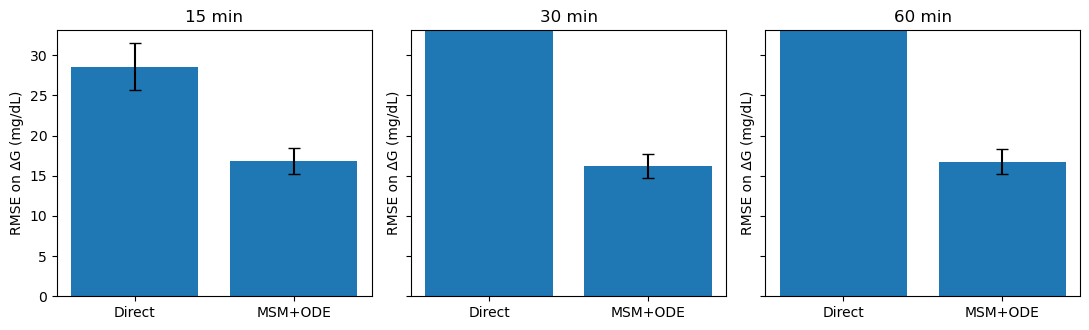

In [4]:
# ================================================================
# Short-horizon validation for Direct SINDy vs MSM+GPS→SINDy (ΔG)
# ================================================================
# Assumes CSV columns:
#   'glucose','carb_input','basal_rate','bolus_volume_delivered',
#   'steps','heart_rate'
# ---------------------------------------------------------------

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from typing import Dict, Iterable, Tuple

from scipy.signal import savgol_filter
from scipy.stats import multivariate_normal

import statsmodels.api as sm
import pysindy as ps


# ------------------------------
# Config (edit as needed)
# ------------------------------
CSV_PATTERN = "HUPA{:04d}P.csv"
NUM_PATIENTS = 28
CSV_SEP = ";"
DT_MIN = 5.0                 # minutes per grid step
HORIZON_STEPS = (3, 6, 12)   # 15, 30, 60 min
STRIDE_STEPS = 12            # 60 min between starts (non-overlapping)
MEAL_THR = 5.0               # grams at window start considered a "meal" event
BOLUS_THR = 0.5              # units at window start considered a "bolus" event
RMSE_FIG_PATH = "rmse_panels.png"


# ================================================================
# 0) Load & basic preprocessing
# ================================================================
def load_all_patients(n: int = NUM_PATIENTS,
                      pattern: str = CSV_PATTERN,
                      sep: str = CSV_SEP) -> pd.DataFrame:
    """Load all patient CSVs into a single DataFrame with a patient_id column."""
    frames = []
    for pid in range(1, n + 1):
        try:
            df = pd.read_csv(pattern.format(pid), sep=sep)
            df["patient_id"] = pid
            frames.append(df)
        except Exception:
            # Skip missing/bad files silently to keep run smooth
            continue
    if not frames:
        raise RuntimeError("No patient files loaded. Check path/pattern.")
    return pd.concat(frames, ignore_index=True)


def preprocess(df_raw: pd.DataFrame, dt_min: float = DT_MIN) -> pd.DataFrame:
    """
    - Sort per patient
    - Reset a uniform 5-min time index per patient
    - Smooth key signals (Savitzky–Golay)
    - Add 1-step lags (5-min lags)
    """
    need_cols = [
        "glucose", "carb_input", "basal_rate", "bolus_volume_delivered",
        "steps", "heart_rate", "patient_id"
    ]
    missing = [c for c in need_cols if c not in df_raw.columns]
    if missing:
        raise ValueError(f"Missing columns in CSVs: {missing}")

    df_sorted = df_raw.sort_values(["patient_id"]).reset_index(drop=True)

    processed = []
    for pid, g in df_sorted.groupby("patient_id", sort=False):
        g = g.reset_index(drop=True).copy()

        # Build a uniform 5-min time grid for this patient
        g["time"] = np.arange(0, dt_min * len(g), dt_min)
        g = g.set_index("time")

        # Smooth a few key continuous series
        for col in ["glucose", "carb_input", "basal_rate", "bolus_volume_delivered"]:
            if len(g[col]) >= 7 and g[col].notna().sum() >= 7:
                g[col] = savgol_filter(
                    g[col].interpolate(limit_direction="both"),
                    window_length=7, polyorder=2, mode="interp"
                )

        # Add 1-step lags (5-min lag)
        for col in ["glucose", "carb_input", "steps", "heart_rate",
                    "basal_rate", "bolus_volume_delivered"]:
            g[f"{col}_lag1"] = g[col].shift(1)

        g = g.dropna()
        processed.append(g)

    dfp = pd.concat(processed).reset_index()  # keep 'time' as a column
    return dfp


# ================================================================
# 1) GPS stabilized weights for TWO continuous doses (ba, bo)
# ================================================================
def pdf_rowwise(Y: np.ndarray, mean_rows: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """Row-wise MVN pdf: each Y[i] uses its own mean mean_rows[i]."""
    return np.array([multivariate_normal.pdf(Y[i], mean=mean_rows[i], cov=cov)
                     for i in range(Y.shape[0])])


def iptw_gps_multi(
    df: pd.DataFrame,
    treatments: Tuple[str, str] = ("basal_rate", "bolus_volume_delivered"),
    confounders: Tuple[str, ...] = ("glucose_lag1", "carb_input_lag1", "heart_rate_lag1", "steps_lag1"),
    eps: float = 1e-3,
    debug: bool = False
) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    """
    Build stabilized inverse-probability weights for two continuous treatments
    using a pragmatic multivariate normal GPS on log-doses.
    """
    d = df.copy()

    # Log-doses to handle zeros / skew
    Y = np.log(np.clip(d[list(treatments)].values, 0, None) + eps)  # (n, 2)

    # Conditional mean for each dose component via OLS on confounders
    X = sm.add_constant(d[list(confounders)], has_constant='add')    # (n, k)
    ols = [sm.OLS(Y[:, j], X).fit() for j in range(Y.shape[1])]
    mu_cond = np.column_stack([m.predict(X) for m in ols])           # (n, 2)

    # Residual covariance (denominator)
    resid = Y - mu_cond
    Sigma_cond = np.cov(resid.T) + 1e-6 * np.eye(resid.shape[1])

    # Marginal mean & covariance (numerator)
    mu_marg = Y.mean(axis=0)                                        # (2,)
    Sigma_marg = np.cov(Y.T) + 1e-6 * np.eye(Y.shape[1])

    # Row-wise densities
    den = pdf_rowwise(Y, mu_cond, Sigma_cond)                       # (n,)
    num = multivariate_normal.pdf(Y, mean=mu_marg, cov=Sigma_marg)  # (n,)

    # Stabilized weights (clipped)
    w = np.clip(num / den, 0.01, 20.0)
    d["iptw"] = w

    if debug:
        print(f"[GPS] Y: {Y.shape}, mu_cond: {mu_cond.shape}")
        print(f"[GPS] Sigma_cond: {Sigma_cond.shape}, mu_marg: {mu_marg.shape}, Sigma_marg: {Sigma_marg.shape}")

    gps_fits = dict(mu_cond=mu_cond, Sigma_cond=Sigma_cond, mu_marg=mu_marg, Sigma_marg=Sigma_marg)
    return d, gps_fits


# ================================================================
# 2) MSM working model & residualization
# ================================================================
def residualize_glucose(df_w: pd.DataFrame) -> Tuple[sm.regression.linear_model.RegressionResultsWrapper, pd.DataFrame]:
    """
    Weighted working model: G_t ~ (ba, bo, c, G_{t-1}, HR_{t-1}, S_{t-1}) with IPTW.
    Adds 'Ghat' and 'G_adj' to df_w.
    """
    X = sm.add_constant(df_w[[
        "basal_rate", "bolus_volume_delivered", "carb_input",
        "glucose_lag1", "heart_rate_lag1", "steps_lag1"
    ]], has_constant='add')
    y = df_w["glucose"].values
    w = df_w["iptw"].values

    wls = sm.WLS(y, X, weights=w).fit()
    df_w["Ghat"] = wls.predict(X)
    df_w["G_adj"] = df_w["glucose"] - df_w["Ghat"] + df_w["glucose"].mean()
    return wls, df_w


# ================================================================
# 3) Fit SINDy models (Direct on G, MSM on G_adj)
# ================================================================
def fit_sindy_direct(df: pd.DataFrame, dt: float = DT_MIN) -> ps.SINDy:
    X = df[["glucose", "carb_input", "basal_rate", "bolus_volume_delivered"]].to_numpy()
    lib = ps.PolynomialLibrary(degree=2)
    opt = ps.STLSQ(threshold=1e-4)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     feature_names=["G", "c", "ba", "bo"])
    model.fit(X, t=dt)
    return model


def fit_sindy_msm(df: pd.DataFrame, dt: float = DT_MIN) -> ps.SINDy:
    X = df[["G_adj", "carb_input", "basal_rate", "bolus_volume_delivered"]].to_numpy()
    lib = ps.PolynomialLibrary(degree=2)
    opt = ps.STLSQ(threshold=1e-4)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     feature_names=["G_adj", "c", "ba", "bo"])
    model.fit(X, t=dt)
    return model


# ================================================================
# 4) Rollouts & evaluation
# ================================================================
def euler_rollout_sindy(model: ps.SINDy,
                        y0: float,
                        inputs_window: np.ndarray,
                        dt: float = DT_MIN,
                        var_index: int = 0) -> float:
    """
    One-step Euler integration over a short window using a fitted SINDy model.
    y0: initial glucose state (G or G_adj)
    inputs_window: array (h, 3) with columns (c, ba, bo)
    """
    y = float(y0)
    for (c, ba, bo) in inputs_window:
        x = np.array([[y, c, ba, bo]])
        dy_dt = model.predict(x)[0, var_index]  # derivative for the first state variable
        y = y + dt * dy_dt
    return y


def evaluate_combined(
    df: pd.DataFrame,
    model_direct: ps.SINDy,
    model_msm: ps.SINDy,
    horizons: Iterable[int] = HORIZON_STEPS,
    stride: int = STRIDE_STEPS,
    dt: float = DT_MIN,
    meal_thr: float = MEAL_THR,
    bolus_thr: float = BOLUS_THR
) -> Dict[int, Dict[str, Tuple[float, float, int]]]:
    """
    Compute per-patient metrics then aggregate across patients (mean ± 95% CI).
    Metrics (per horizon): RMSE/MAE for Direct & MSM, plus sign accuracy after meal/bolus.
    """
    per_patient = {
        h: {
            "rmse_direct": [], "rmse_msm": [],
            "mae_direct": [],  "mae_msm": [],
            "sign_meal_msm": [], "sign_bolus_msm": []
        } for h in horizons
    }

    for pid, g in df.groupby("patient_id", sort=False):
        g = g.copy().reset_index(drop=True)

        G = g["glucose"].to_numpy()
        Gadj = g["G_adj"].to_numpy()
        Ghat = g["Ghat"].to_numpy()
        c_arr = g["carb_input"].to_numpy()
        ba_arr = g["basal_rate"].to_numpy()
        bo_arr = g["bolus_volume_delivered"].to_numpy()

        max_h = max(horizons)
        starts = np.arange(0, len(g) - max_h, stride)  # e.g., every 60min

        for h in horizons:
            dG_obs_list, dG_dir_list, dG_msm_list = [], [], []
            meal_obs, meal_pred = [], []
            bolus_obs, bolus_pred = [], []

            for t0 in starts:
                t1 = t0 + h
                window = np.column_stack([c_arr[t0:t1], ba_arr[t0:t1], bo_arr[t0:t1]])
                if window.shape[0] < h:
                    continue

                # Direct model on raw G
                G0 = G[t0]
                G_end_pred = euler_rollout_sindy(model_direct, G0, window, dt=dt, var_index=0)

                # MSM model on G_adj, then map back to raw G:
                # ΔG = ΔG_adj + (Ghat_{t+h} - Ghat_t)
                Gadj0 = Gadj[t0]
                Gadj_end_pred = euler_rollout_sindy(model_msm, Gadj0, window, dt=dt, var_index=0)

                dG_obs = G[t1] - G0
                dG_dir = G_end_pred - G0
                dG_msm = (Gadj_end_pred - Gadj0) + (Ghat[t1] - Ghat[t0])

                dG_obs_list.append(dG_obs)
                dG_dir_list.append(dG_dir)
                dG_msm_list.append(dG_msm)

                # Event-based sign checks at window start
                if c_arr[t0] >= meal_thr:
                    meal_obs.append(dG_obs)
                    meal_pred.append(dG_msm)
                if bo_arr[t0] >= bolus_thr:
                    bolus_obs.append(dG_obs)
                    bolus_pred.append(dG_msm)

            # Per-patient metrics for this horizon
            if not dG_obs_list:
                continue

            dG_obs = np.array(dG_obs_list)
            d_dir = np.array(dG_dir_list)
            d_msm = np.array(dG_msm_list)

            rmse = lambda a, b: np.sqrt(np.mean((a - b) ** 2))
            mae = lambda a, b: np.mean(np.abs(a - b))
            sacc = lambda a, b: np.mean(np.sign(a) == np.sign(b)) if len(a) > 0 else np.nan

            per_patient[h]["rmse_direct"].append(rmse(d_dir, dG_obs))
            per_patient[h]["rmse_msm"].append(rmse(d_msm, dG_obs))
            per_patient[h]["mae_direct"].append(mae(d_dir, dG_obs))
            per_patient[h]["mae_msm"].append(mae(d_msm, dG_obs))

            if meal_obs:
                per_patient[h]["sign_meal_msm"].append(sacc(np.array(meal_pred), np.array(meal_obs)))
            if bolus_obs:
                per_patient[h]["sign_bolus_msm"].append(sacc(np.array(bolus_pred), np.array(bolus_obs)))

    # Aggregate across patients: mean ± 95% CI
    def mean_ci(xs: Iterable[float]) -> Tuple[float, float]:
        xs = np.array(xs, dtype=float)
        xs = xs[~np.isnan(xs)]
        if len(xs) == 0:
            return (np.nan, np.nan)
        m = xs.mean()
        se = xs.std(ddof=1) / np.sqrt(len(xs))
        return (m, 1.96 * se)

    summary: Dict[int, Dict[str, Tuple[float, float, int]]] = {}
    for h in horizons:
        row = {}
        for metric, vals in per_patient[h].items():
            m, ci = mean_ci(vals)
            row[metric] = (m, ci, len(vals))
        summary[h] = row
    return summary


def print_summary(summary: Dict[int, Dict[str, Tuple[float, float, int]]]) -> None:
    """Nicely print mean ± 95% CI and sample sizes per horizon."""
    for h, row in summary.items():
        print(f"\n=== Horizon {h} steps (~{int(h * DT_MIN)} min) ===")
        for metric in ["rmse_direct", "rmse_msm", "mae_direct", "mae_msm",
                       "sign_meal_msm", "sign_bolus_msm"]:
            m, ci, n = row[metric]
            label = metric.replace("_", " ").upper()
            if np.isnan(m):
                print(f"  {label}: n=0")
            else:
                unit = " (mg/dL)" if "RMSE" in label or "MAE" in label else ""
                print(f"  {label}: {m:.3f} ± {ci:.3f}{unit}   [n={n}]")


def plot_rmse_bars(summary: Dict[int, Dict[str, Tuple[float, float, int]]],
                   savepath: str | None = RMSE_FIG_PATH) -> None:
    """3-panel RMSE bar chart with 95% CIs for Direct vs MSM+ODE at 15/30/60 min."""
    horizons = sorted(summary.keys())
    direct = [summary[h]["rmse_direct"][0] for h in horizons]
    msm = [summary[h]["rmse_msm"][0] for h in horizons]
    ci_d = [summary[h]["rmse_direct"][1] for h in horizons]
    ci_m = [summary[h]["rmse_msm"][1] for h in horizons]

    fig, axes = plt.subplots(1, 3, figsize=(11, 3.4), sharey=True)
    titles = [f"{int(h * DT_MIN)} min" for h in horizons]

    for ax, title, d, m, cid, cim in zip(axes, titles, direct, msm, ci_d, ci_m):
        ax.bar(["Direct", "MSM+ODE"], [d, m], yerr=[cid, cim], capsize=4)
        ax.set_title(title)
        ax.set_ylabel("RMSE on ΔG (mg/dL)")
        ax.set_ylim(bottom=0)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


# ================================================================
# Main
# ================================================================
if __name__ == "__main__":
    # 1) Load & preprocess
    df_raw = load_all_patients(n=NUM_PATIENTS, pattern=CSV_PATTERN, sep=CSV_SEP)
    df = preprocess(df_raw, dt_min=DT_MIN)

    # 2) GPS → MSM residualization
    df_w, gps_fits = iptw_gps_multi(df, debug=True)
    wls, df_w = residualize_glucose(df_w)
    print("\n[Weights] IPTW summary:\n", df_w["iptw"].describe())

    # 3) Fit population-level SINDy models
    model_direct = fit_sindy_direct(df_w, dt=DT_MIN)
    model_msm = fit_sindy_msm(df_w, dt=DT_MIN)

    # Optional: print learned equations
    # print("\n--- Direct SINDy (G) ---\n", model_direct.equations()[0])
    # print("\n--- MSM+GPS→SINDy (G_adj) ---\n", model_msm.equations()[0])

    # 4) Evaluate short-horizon rollouts
    summary = evaluate_combined(
        df_w, model_direct, model_msm,
        horizons=HORIZON_STEPS, stride=STRIDE_STEPS, dt=DT_MIN,
        meal_thr=MEAL_THR, bolus_thr=BOLUS_THR
    )
    print_summary(summary)
    plot_rmse_bars(summary, savepath=RMSE_FIG_PATH)
